In [1]:
from fireworks import PyTorch_Model, Message, HookedPassThroughPipe, Experiment
from fireworks.toolbox import ShufflerPipe, TensorPipe, BatchingPipe, FunctionPipe
from fireworks.toolbox.preprocessing import train_test_split
from fireworks.extensions import IgniteJunction
from fireworks.core import PyTorch_Model
import pandas as pd
import torch
from torchvision.datasets.mnist import FashionMNIST
from os import environ as env
from itertools import count
import matplotlib.pyplot as plt 
import visdom

env_name = 'mnist_fashion'
# vis = visdom.Visdom(env=env_name) # If you have a running Visdom server, you can uncomment this to generate plots.
description = "Here, we will train a convolutional neural network on the Fashion MNIST dataset to demonstrate the usage of Fireworks."
experiment = Experiment(env_name, description=description)

/usr/local/lib/python3.5/dist-packages/sqlalchemy/sql/functions.py:68: SAWarning: The GenericFunction 'array_agg' is already registered and is going to be overriden.
  "is going to be overriden.".format(identifier))
/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


/media/saad/Data/MNIST


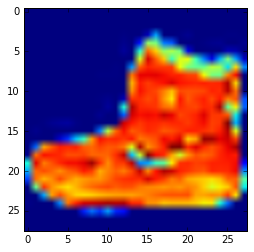

In [2]:
mnist_dir = env.get('MNIST_DIR', './MNIST/')
print(mnist_dir)

# First, we download our dataset and plot one of its elements as an example.
mnist = FashionMNIST(mnist_dir, download=True)
dataset = Message({'examples': mnist.data, 'labels': mnist.targets})
example = dataset['examples'][0]
plt.imshow(example)
plt.show()

In [3]:
# Now we construct our training and test sets as a pipeline.
train, test = train_test_split(dataset, test=.1)

# We can compose pipes to create an input pipeline that will shuffle the training set on each iteration and produce minibatches formatted for our image classifier.
shuffler = ShufflerPipe(train)
minibatcher = BatchingPipe(shuffler, batch_size=100)
to_cuda = TensorPipe(minibatcher, columns=['examples', 'labels']) # By default, all columns will be moved to Cuda if possible, but you can explicitly specify which ones as well

def tensor_to_float(batch, column='examples'):
    """ This converts the images from bytes to floats which is the data type that torch.nn.Conv2d expects. """
    batch[column] = batch[column].float()
    return batch
 
def reshape_batch(batch, column='examples'):
    """ This reshapes the batch to have an extra dimension corresponding to the input channels so we can apply the torch.nn.Conv2d operation in our model. """
    shape = batch[column].shape
    new_shape = torch.Size([shape[0], 1, shape[1], shape[2]])
    batch[column] = batch[column].reshape(new_shape)
    return batch

def normalize_batch(batch, column='examples'):
    """ Normalizes pixel intensities to fall between 0 and 1. """
    batch[column] /= 255. 
    return batch

to_float = FunctionPipe(input=to_cuda, function=tensor_to_float)
normalized = FunctionPipe(input=to_float, function=normalize_batch)
training_set = FunctionPipe(input=normalized, function=reshape_batch)

# We can also compose a pipeline in one go like we do here for the test set.
test_set = \
    FunctionPipe(
        input=FunctionPipe(
            input=FunctionPipe(
                input=TensorPipe(
                    input=BatchingPipe(
                        input=test,
                        batch_size=100
                        ), 
                    columns=['examples', 'labels']
                ), 
                function=to_float
            ),
            function=normalize_batch
        ),
        function=reshape_batch
    )


In [4]:
# Construct Model
class mnistModel(PyTorch_Model):
    """ Embeds each image into a 10-dimensional vector. """
    required_components = ['in_column', 'out_column', 'conv1', 'pool1', 'conv2', 'pool2']

    def init_default_components(self):

        self.components['in_column'] = 'examples'
        self.components['out_column'] = 'embeddings'
        self.components['conv1'] = torch.nn.Conv2d(1, 64, 2, padding=1)
        self.components['pool1'] = torch.nn.MaxPool2d(2)
        self.components['conv2'] = torch.nn.Conv2d(64, 32, 2)
        self.components['pool2'] = torch.nn.MaxPool2d(2)
        self.components['nonlinearity'] = torch.nn.ELU()

    def forward(self, batch):
        
        embedding = batch[self.in_column]
        embedding = self.nonlinearity(self.conv1(embedding))
        embedding = self.pool1(embedding)
        embedding = self.nonlinearity(self.conv2(embedding))
        embedding = self.pool2(embedding)
        embedding = embedding.reshape(len(batch), 1152)
        batch[self.out_column] = embedding
        return batch

class Classifier(PyTorch_Model):
    """ Uses the input embedding to perform a classification. """    
    required_components = ['in_column', 'out_column', 'linear_layer']

    def init_default_components(self):
        self.components['in_column'] = 'embeddings'
        self.components['out_column'] = 'predictions'
        self.components['linear1'] = torch.nn.Linear(1152, 256)
        self.components['linear2'] = torch.nn.Linear(256, 10)
        self.components['nonlinearity'] = torch.nn.ELU()
        self.components['softmax'] = torch.nn.Softmax(dim=1)

    def forward(self, batch):
        
        predictions = batch[self.in_column]
        predictions = self.nonlinearity(self.linear1(predictions))
        predictions = self.softmax(self.linear2(predictions))        
        batch[self.out_column] = predictions
        return batch 

# All function calls to the classifier will call the embedder first
# ie. classifier(x) is equivalent to classifier.forward(embedder.forward(x))
embedder = mnistModel()
classifier = Classifier(input=embedder)

if torch.cuda.is_available():
    embedder.cuda()
    classifier.cuda()

In [5]:
# Set up loss function and training loop
ce_loss = torch.nn.CrossEntropyLoss()
loss = lambda batch: ce_loss(batch['predictions'], batch['labels'])

# By default, this Junction applies a standard training closure of evaluating the model,
# computing gradients of the loss, and backpropagating using the chosen optimizer.
trainer = IgniteJunction(
    components={
        'model': classifier, 
        'dataset': training_set
        }, 
    loss=loss, optimizer='Adam', 
    lr=.0001, weight_decay=.001, 
    visdom=False, # If you have a running Visdom server, you can set this to true to get plots
    environment=env_name
    )

trainer.run(max_epochs=10) # This will take almost 15 minutes on CPU and less than 30 seconds on GPU

Epoch[1] Iteration: 0 Time: 0:00:00 Loss: 2.30
Epoch[1] Iteration: 100 Time: 0:00:16 Loss: 1.91
Epoch[1] Iteration: 200 Time: 0:00:31 Loss: 1.71
Epoch[1] Iteration: 300 Time: 0:00:46 Loss: 1.77
Epoch[1] Iteration: 400 Time: 0:01:04 Loss: 1.72
Epoch[1] Iteration: 500 Time: 0:01:23 Loss: 1.72
Epoch[2] Iteration: 600 Time: 0:01:39 Loss: 1.67
Epoch[2] Iteration: 700 Time: 0:01:55 Loss: 1.75
Epoch[2] Iteration: 800 Time: 0:02:10 Loss: 1.62
Epoch[2] Iteration: 900 Time: 0:02:26 Loss: 1.68
Epoch[2] Iteration: 1000 Time: 0:02:43 Loss: 1.71
Epoch[3] Iteration: 1100 Time: 0:02:58 Loss: 1.64
Epoch[3] Iteration: 1200 Time: 0:03:14 Loss: 1.65
Epoch[3] Iteration: 1300 Time: 0:03:30 Loss: 1.72
Epoch[3] Iteration: 1400 Time: 0:03:45 Loss: 1.72
Epoch[3] Iteration: 1500 Time: 0:04:01 Loss: 1.68
Epoch[3] Iteration: 1600 Time: 0:04:17 Loss: 1.68
Epoch[4] Iteration: 1700 Time: 0:04:33 Loss: 1.63
Epoch[4] Iteration: 1800 Time: 0:04:50 Loss: 1.69
Epoch[4] Iteration: 1900 Time: 0:05:07 Loss: 1.67
Epoch[4] Ite

In [6]:
# Now that we've trained our model, we can compute some metrics on the test set.
# Here, we construct a Pipe that will compute metrics such as sensitivity, specificity, f1, etc.
# on the test set.

classes = {i: class_name for i, class_name in zip(count(), mnist.classes)}
class Metrics(HookedPassThroughPipe):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.true_positives = {class_name: 0 for class_name in classes.values()}
        self.true_negatives = {class_name: 0 for class_name in classes.values()}
        self.false_positives = {class_name: 0 for class_name in classes.values()}
        self.false_negatives = {class_name: 0 for class_name in classes.values()}
        self.total_count = 0
        self.label_counts = {class_name: 0 for class_name in classes.values()}
        self.prediction_counts = {class_name: 0 for class_name in classes.values()}

    def _call_hook(self, batch):
        """ 
        This will get called every time the model is called. As a result, this pipe will continuously update
        itself as we iterate through the test set.
        """
        labels = batch['labels']
        predictions = torch.max(batch['predictions'],1)[1]
        correct_indices = (predictions == labels).nonzero().flatten().tolist()
        incorrect_indices = (predictions != labels).nonzero().flatten().tolist()
        for index, name in classes.items():
            self.label_counts[name] += int(sum(labels == index)) # How often the class showed up
            self.prediction_counts[name] += int(sum(predictions == index)) # How often the class was predicted
            self.true_positives[name] += int(sum(predictions[correct_indices] == index)) # How often the correct prediction was for thsi class
            self.true_negatives[name] += int(sum(predictions[correct_indices] != index)) # How often the correct prediction was not for the class; ie. how often the prediction was a true negative for this class
            self.false_positives[name] += int(sum(predictions[incorrect_indices] == index)) # How often a wrong prediction was for this class
            self.false_negatives[name] += int(sum(predictions[incorrect_indices] != index)) # How often a wrong prediction was for another class; ie. how often the prediction was a false negative for this class
        self.total_count += len(batch)
        return batch

    def compile_metrics(self):
        """ 
        After we have gone through the entire test set, we can call this method to compute the actual metrics.
        """
        class_names = classes.values()
        negative_counts = {name: sum(self.label_counts[other] for other in class_names if other != name) for name in class_names}
        self.sensitivity = {name: self.true_positives[name] / self.label_counts[name] for name in class_names}
        self.specificity = {name: self.true_negatives[name] / negative_counts[name] for name in class_names}
        negative_prediction_counts = {name: sum(self.prediction_counts[other] for other in class_names if other != name) for name in class_names}
        self.ppv = {name: self.true_positives[name] / self.prediction_counts[name] for name in class_names}
        self.npv = {name: self.true_negatives[name] / negative_prediction_counts[name] for name in class_names}
        self.f1 = {name: 2 / (1/self.ppv[name] + 1/self.sensitivity[name]) for name in class_names}
        self.accuracy = {name: (self.true_positives[name] + self.true_negatives[name]) / self.total_count for name in class_names}

    def get_metrics(self):
        """
        Lastly, we will use this method to return the computed metrics as a Pandas DataFrame.
        """
        columns = ['sensitivity', 'specificity', 'ppv', 'npv', 'f1', 'accuracy']
        df = pd.DataFrame(columns=columns, index=classes.values())
        for attribute in columns:
            value = getattr(self, attribute)
            df[attribute] = [value[key] for key in df.index]

        return df

# This class is implemented a a HookedPassThroughPipe, meaning that it's _call_hook method will be applied every time
# The class is called like a function, and this call will pass through to its input.
metrics_computer = Metrics(input=classifier)

In [7]:
for batch in test_set:
    # We can simply call this object repeatedly on batches in the test set
    # This operation is equivalent to metrics_computer._call_hook(classifier(batch))
    metrics_computer(batch)

metrics_computer.compile_metrics()
df = metrics_computer.get_metrics()
print(df)


             sensitivity  specificity       ppv       npv        f1  accuracy
T-shirt/top     0.863124     0.852389  0.765714  0.865094  0.811506    0.8535
Trouser         0.958065     0.841450  0.990000  0.838333  0.973770    0.8535
Pullover        0.759812     0.864628  0.793443  0.860297  0.776263    0.8535
Dress           0.927152     0.845256  0.827179  0.856848  0.874317    0.8535
Coat            0.702479     0.870436  0.763016  0.862760  0.731497    0.8535
Sandal          0.950000     0.843566  0.969035  0.841864  0.959423    0.8535
Shirt           0.543189     0.888107  0.631274  0.874498  0.583929    0.8535
Sneaker         0.958559     0.842792  0.895623  0.848872  0.926023    0.8535
Bag             0.960396     0.841491  0.925278  0.845094  0.942510    0.8535
Ankle boot      0.930508     0.845102  0.969965  0.841369  0.949827    0.8535


In [8]:
# You can also convert this DataFrame to a Message.
m = Message(df)
print(m)

Message with 
 Tensors: 
 TensorMessage: {} 
 Metadata: 
              accuracy        f1       npv       ppv  sensitivity  specificity
T-shirt/top    0.8535  0.811506  0.865094  0.765714     0.863124     0.852389
Trouser        0.8535  0.973770  0.838333  0.990000     0.958065     0.841450
Pullover       0.8535  0.776263  0.860297  0.793443     0.759812     0.864628
Dress          0.8535  0.874317  0.856848  0.827179     0.927152     0.845256
Coat           0.8535  0.731497  0.862760  0.763016     0.702479     0.870436
Sandal         0.8535  0.959423  0.841864  0.969035     0.950000     0.843566
Shirt          0.8535  0.583929  0.874498  0.631274     0.543189     0.888107
Sneaker        0.8535  0.926023  0.848872  0.895623     0.958559     0.842792
Bag            0.8535  0.942510  0.845094  0.925278     0.960396     0.841491
Ankle boot     0.8535  0.949827  0.841369  0.969965     0.930508     0.845102


In [9]:
# Lastly, we can save our results from this experiment
# At it's simplest, the experiment object gives you a way of organizing files.
# You can uses its open() method to get a file handle or path string to a file 
# inside its experiment directory.
# Each time you create an experiment, a new experiment directory will be created automatically.
df.to_csv(experiment.open("metrics.csv", string_only=True))
# Since our models are still subclasses of torch.nn.module, we can save them using the standard torch.save feature
# but if we want, we can also save their parameters in other formats such as JSON
state = embedder.get_state()
Message.from_objects(state).to('json', path=experiment.open("embedder.json",string_only=True))
state = classifier.get_state()
Message.from_objects(state).to('json', path=experiment.open("classifier.json",string_only=True))